In [775]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf
import xgboost as xgb
from joblib import parallel_backend
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from prophet import Prophet # Cringe, I know

from IPython.display import display, HTML


In [705]:
tmax = pd.read_csv("new_england_tmax.csv", index_col = "date", parse_dates=True)
tavg = pd.read_csv("new_england_tavg.csv", index_col = "date", parse_dates=True)
tmin = pd.read_csv("new_england_tmin.csv", index_col = "date", parse_dates=True)
prcp = pd.read_csv("new_england_prcp.csv", index_col = "date", parse_dates=True)

data = [tavg, tmax, tmin, prcp]
data = pd.concat(data, axis="columns")
data.columns = ["tavg", "tmax", "tmin", "prcp"]
data

,tavg,tmax,tmin,prcp
date,,,,
1951-01-01,-7.01,-1.70,-12.32,0.33
1951-01-02,-6.75,-0.66,-12.84,0.00
1951-01-03,-1.29,3.95,-6.53,0.22
1951-01-04,4.18,7.64,0.72,2.43
1951-01-05,-0.57,6.57,-7.71,1.05
...,...,...,...,...
2021-12-27,-2.83,0.59,-6.25,0.08
2021-12-28,-3.98,0.08,-8.05,0.80
2021-12-29,-1.90,1.21,-5.02,1.97


In [706]:
data["day"] = data.index.day_of_year
data["sin_encoded_day"] = round(np.sin((data.day/365)*2*np.pi),3)
data["cos_encoded_day"] = round(np.cos((data.day/365)*2*np.pi),3)
data

,tavg,tmax,tmin,prcp,day,sin_encoded_day,cos_encoded_day
date,,,,,,,
1951-01-01,-7.01,-1.70,-12.32,0.33,1,0.017,1.000
1951-01-02,-6.75,-0.66,-12.84,0.00,2,0.034,0.999
1951-01-03,-1.29,3.95,-6.53,0.22,3,0.052,0.999
1951-01-04,4.18,7.64,0.72,2.43,4,0.069,0.998
1951-01-05,-0.57,6.57,-7.71,1.05,5,0.086,0.996
...,...,...,...,...,...,...,...
2021-12-27,-2.83,0.59,-6.25,0.08,361,-0.069,0.998
2021-12-28,-3.98,0.08,-8.05,0.80,362,-0.052,0.999
2021-12-29,-1.90,1.21,-5.02,1.97,363,-0.034,0.999


<AxesSubplot:xlabel='day', ylabel='sin_encoded_day'>

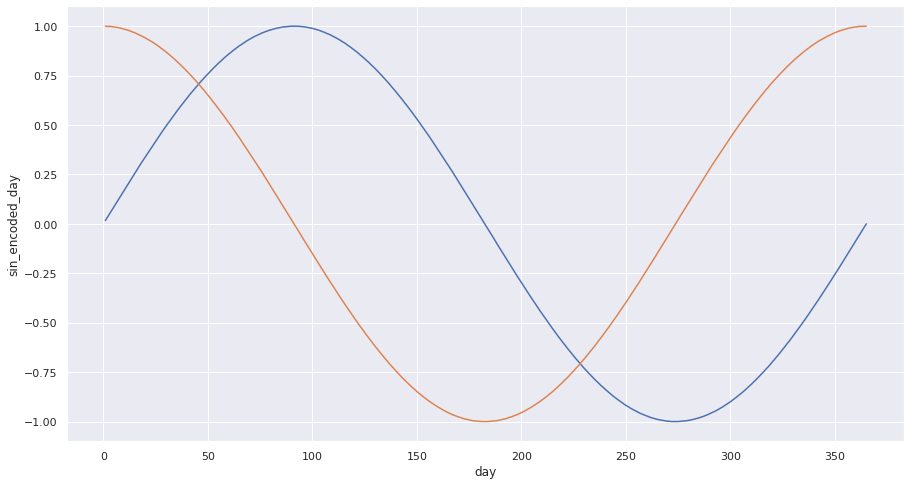

In [707]:
sns.lineplot(x =data.day["2021-01-01":], y=data["2021-01-01":].sin_encoded_day)
sns.lineplot(x =data.day["2021-01-01":], y=data["2019-01-01":].cos_encoded_day)

In [708]:
months = pd.get_dummies(data.index.month, columns=data.index)
months.index = data.index
data = data.join(months)
data

,tavg,tmax,tmin,prcp,day,sin_encoded_day,cos_encoded_day,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,,,,,,,,
1951-01-01,-7.01,-1.70,-12.32,0.33,1,0.017,1.000,1,0,0,0,0,0,0,0,0,0,0,0
1951-01-02,-6.75,-0.66,-12.84,0.00,2,0.034,0.999,1,0,0,0,0,0,0,0,0,0,0,0
1951-01-03,-1.29,3.95,-6.53,0.22,3,0.052,0.999,1,0,0,0,0,0,0,0,0,0,0,0
1951-01-04,4.18,7.64,0.72,2.43,4,0.069,0.998,1,0,0,0,0,0,0,0,0,0,0,0
1951-01-05,-0.57,6.57,-7.71,1.05,5,0.086,0.996,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,-2.83,0.59,-6.25,0.08,361,-0.069,0.998,0,0,0,0,0,0,0,0,0,0,0,1
2021-12-28,-3.98,0.08,-8.05,0.80,362,-0.052,0.999,0,0,0,0,0,0,0,0,0,0,0,1
2021-12-29,-1.90,1.21,-5.02,1.97,363,-0.034,0.999,0,0,0,0,0,0,0,0,0,0,0,1


<AxesSubplot:xlabel='date'>

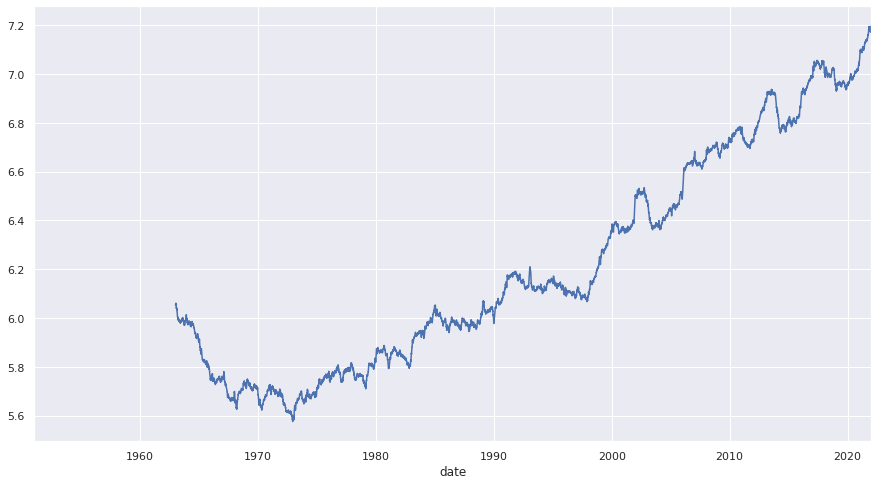

In [709]:
data["tavg_trend"] = data["tavg"].rolling(4383).mean()
data.tavg_trend.plot()

In [710]:
data = data[data.index > "1970-01-01"]
# data = data.resample("W").mean()

y30 = data.tavg.shift(-30).dropna()
y182 = data.tavg.shift(-182).dropna()
y365 = data.tavg.shift(-365).dropna()
display(y365)

date
1970-01-02   -9.04
1970-01-03   -5.84
1970-01-04   -5.98
1970-01-05   -3.54
1970-01-06   -1.37
              ... 
2020-12-27   -2.83
2020-12-28   -3.98
2020-12-29   -1.90
2020-12-30   -1.52
2020-12-31    0.49
Name: tavg, Length: 18627, dtype: float64

In [711]:
# data = data[data.index < "2015-01-06"]
data = data[data.index < "2021-01-01"]
data.columns = data.columns.astype(str)
data

,tavg,tmax,tmin,prcp,day,sin_encoded_day,cos_encoded_day,1,2,3,4,5,6,7,8,9,10,11,12,tavg_trend
date,,,,,,,,,,,,,,,,,,,,
1970-01-02,-12.34,-7.55,-17.13,0.00,2,0.034,0.999,1,0,0,0,0,0,0,0,0,0,0,0,5.684641
1970-01-03,-12.44,-7.18,-17.69,0.00,3,0.052,0.999,1,0,0,0,0,0,0,0,0,0,0,0,5.684132
1970-01-04,-12.90,-6.28,-19.52,0.89,4,0.069,0.998,1,0,0,0,0,0,0,0,0,0,0,0,5.684775
1970-01-05,-13.48,-7.35,-19.62,0.00,5,0.086,0.996,1,0,0,0,0,0,0,0,0,0,0,0,5.685314
1970-01-06,-11.36,-5.48,-17.24,0.05,6,0.103,0.995,1,0,0,0,0,0,0,0,0,0,0,0,5.685035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,-2.59,1.56,-6.74,0.81,362,-0.052,0.999,0,0,0,0,0,0,0,0,0,0,0,1,7.049405
2020-12-28,-3.97,-0.05,-7.89,0.00,363,-0.034,0.999,0,0,0,0,0,0,0,0,0,0,0,1,7.048257
2020-12-29,-0.09,4.60,-4.77,0.68,364,-0.017,1.000,0,0,0,0,0,0,0,0,0,0,0,1,7.047107


In [712]:
x_train, x_test, y_train, y_test = train_test_split(data, y365, test_size=0.33, shuffle=False)

In [713]:
y_test

date
2004-03-04   -10.24
2004-03-05    -8.46
2004-03-06    -5.05
2004-03-07    -3.64
2004-03-08    -2.75
              ...  
2020-12-27    -2.83
2020-12-28    -3.98
2020-12-29    -1.90
2020-12-30    -1.52
2020-12-31     0.49
Name: tavg, Length: 6147, dtype: float64

In [714]:
x_train["1970-01-01":]

,tavg,tmax,tmin,prcp,day,sin_encoded_day,cos_encoded_day,1,2,3,4,5,6,7,8,9,10,11,12,tavg_trend
date,,,,,,,,,,,,,,,,,,,,
1970-01-02,-12.34,-7.55,-17.13,0.00,2,0.034,0.999,1,0,0,0,0,0,0,0,0,0,0,0,5.684641
1970-01-03,-12.44,-7.18,-17.69,0.00,3,0.052,0.999,1,0,0,0,0,0,0,0,0,0,0,0,5.684132
1970-01-04,-12.90,-6.28,-19.52,0.89,4,0.069,0.998,1,0,0,0,0,0,0,0,0,0,0,0,5.684775
1970-01-05,-13.48,-7.35,-19.62,0.00,5,0.086,0.996,1,0,0,0,0,0,0,0,0,0,0,0,5.685314
1970-01-06,-11.36,-5.48,-17.24,0.05,6,0.103,0.995,1,0,0,0,0,0,0,0,0,0,0,0,5.685035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-02-28,-3.74,3.39,-10.87,0.00,59,0.850,0.527,0,1,0,0,0,0,0,0,0,0,0,0,6.364447
2004-02-29,-1.36,5.92,-8.64,0.00,60,0.859,0.512,0,1,0,0,0,0,0,0,0,0,0,0,6.365745
2004-03-01,0.90,8.10,-6.30,0.01,61,0.867,0.498,0,0,1,0,0,0,0,0,0,0,0,0,6.369236


In [118]:

scaler = StandardScaler()


train_scaled = scaler.fit_transform(x_train)
test__scaled = scaler.fit_transform(x_test)

train_scaled

array([[-1.82398612, -1.78025846, -1.85008217, ..., -0.31126053,
        -0.31692747, -1.34713323],
       [-1.83043209, -1.82605597, -1.81509084, ..., -0.31126053,
        -0.31692747, -1.36104301],
       [-1.76373032, -1.77385763, -1.73370005, ..., -0.31126053,
        -0.31692747, -1.40331069],
       ...,
       [-1.39140553, -1.30812939, -1.46407509, ..., -0.31126053,
        -0.31692747,  2.23835426],
       [-1.38145632, -1.23483534, -1.52231408, ..., -0.31126053,
        -0.31692747,  2.25524775],
       [-1.33983778, -1.26269248, -1.4071303 , ..., -0.31126053,
        -0.31692747,  2.24945166]])

In [756]:
params = {"loss":"absolute_error", 
          "learning_rate":0.05, 
          "n_estimators": 75, 
          "max_depth":7, 
          "subsample": 0.1,
          "random_state": 1234,
          "verbose":1}

In [757]:
#model = xgb.XGBRegressor()
#model = LogisticRegression()
#model = HistGradientBoostingRegressor(**params)
model = GradientBoostingRegressor(**params)
# model = RandomForestRegressor()
# model = MLPRegressor()
with parallel_backend('threading', n_jobs=2):
    model.fit(x_train, y_train)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           8.6538           0.4064            1.09s
         2           8.1258           0.3730            0.99s
         3           7.7496           0.3535            0.88s
         4           7.4551           0.3382            0.84s
         5           7.1041           0.3108            0.79s
         6           6.7853           0.2859            0.75s
         7           6.4508           0.2702            0.72s
         8           6.2623           0.2493            0.70s
         9           6.2310           0.2443            0.69s
        10           5.7305           0.2145            0.67s
        20           4.2959           0.1039            0.57s
        30           3.5669           0.0457            0.47s
        40           3.3154           0.0218            0.36s
        50           3.0357           0.0060            0.25s
        60           3.0374           0.0049            0.15s
       

In [758]:
predictions = model.predict(x_test)
predictions = pd.DataFrame(predictions, columns = ["predicted avg temp"])
predictions.index = x_test.index

y = y_test.reset_index(drop=True)
x = predictions["predicted avg temp"].reset_index(drop=True)

predictions = pd.concat([x, y],axis="columns")
predictions.index = x_test.index
predictions

,predicted avg temp,tavg
date,,
2004-03-04,-3.702786,-10.24
2004-03-05,-3.607781,-8.46
2004-03-06,-2.567806,-5.05
2004-03-07,-2.466746,-3.64
2004-03-08,-2.567524,-2.75
...,...,...
2020-12-27,-6.915416,-2.83
2020-12-28,-6.549747,-3.98
2020-12-29,-7.286339,-1.90


(20.334312286791608, 3.546419364957391, 0.7575507605999524)

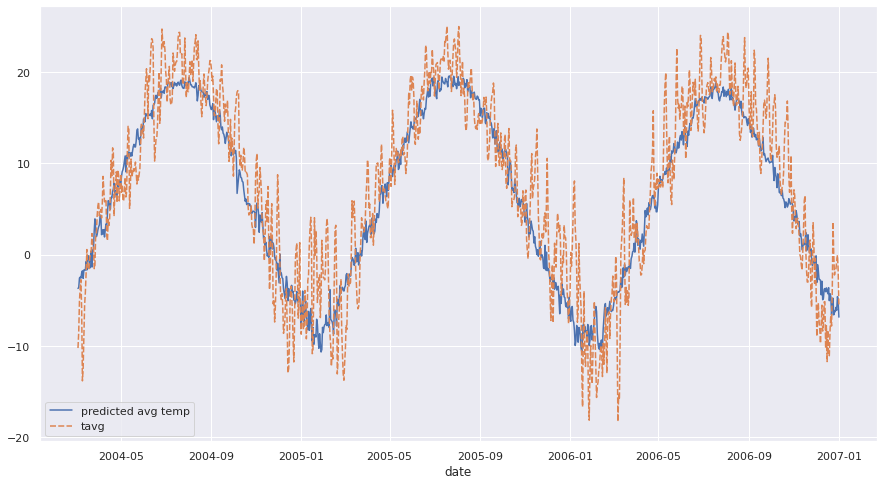

In [759]:

sns.lineplot(predictions[:"2007-01-01"])

mse_value = mse(x, y_test)
mae_value = mae(x, y_test)
r2   = r2_score(x, y_test)
mse_value, mae_value, r2

,predicted avg temp,tavg
count,0.0,6147.000000
mean,NaN,1.784818
std,NaN,4.141440
min,NaN,-14.661019
25%,NaN,-0.850394
50%,NaN,1.748011
75%,NaN,4.469715
max,NaN,18.476375


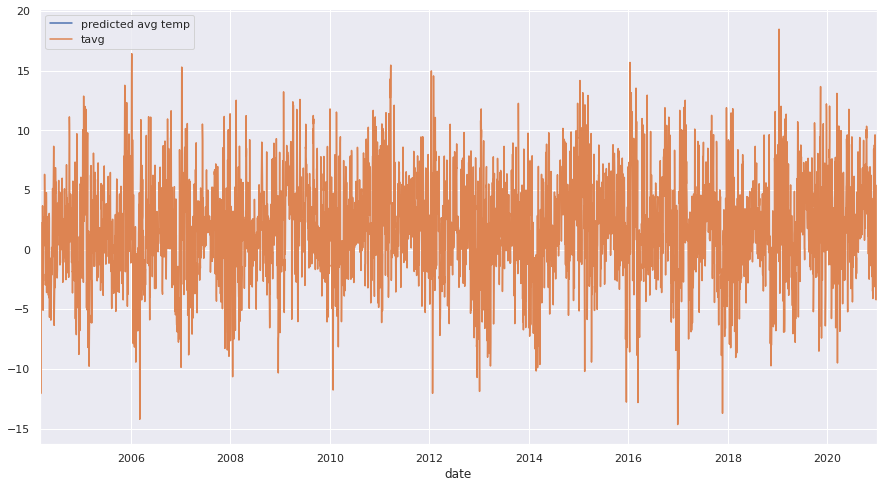

In [777]:
diff = predictions.diff(axis="columns")
diff.plot()

diff.describe()

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

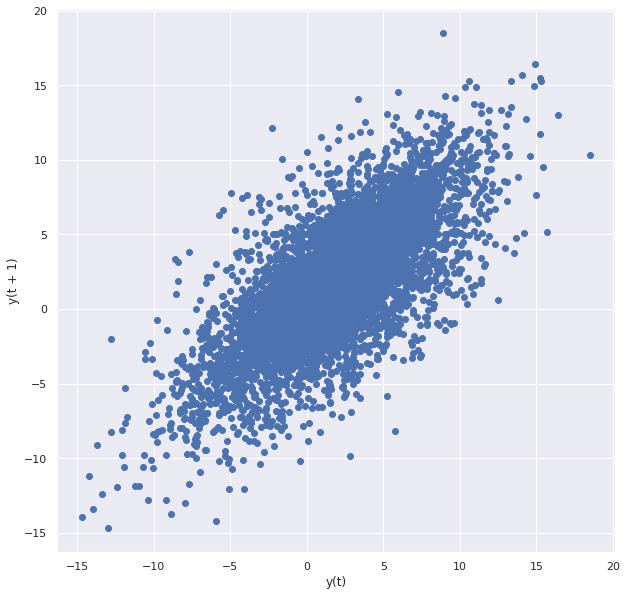

In [786]:
plt.rcParams["figure.figsize"] = (10,10)
pd.plotting.lag_plot(diff, lag=(1))

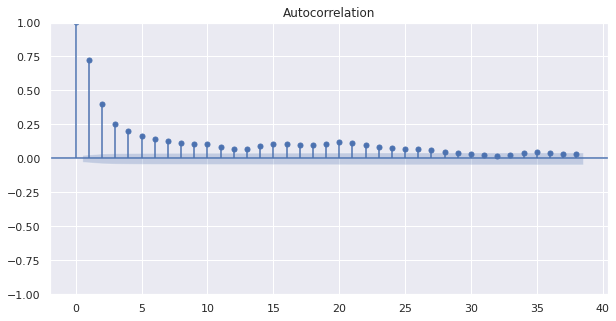

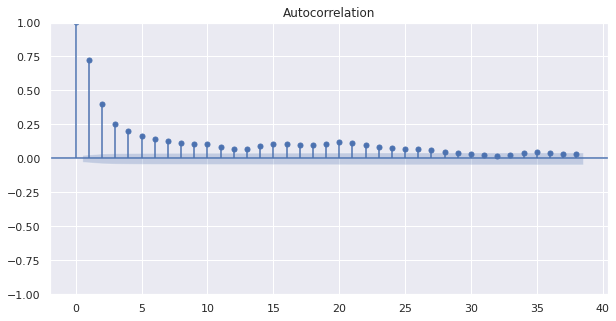

In [784]:
plt.rcParams["figure.figsize"] = (10,5)
plot_acf(diff["tavg"])

<AxesSubplot:xlabel='date'>

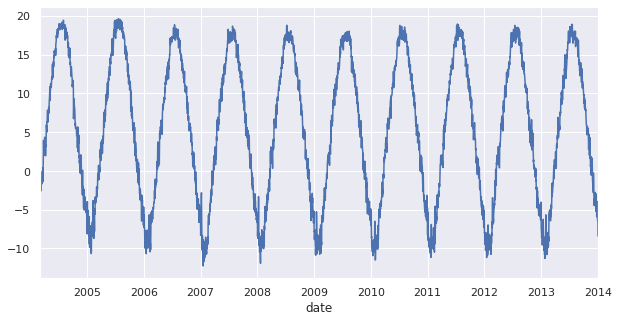

In [785]:
predictions[:"2014-01-01"]["predicted avg temp"].plot()